# Betfair predictions for the 2019 vote

![predictions](predictions.png)

[Betfair](https://www.betfair.com/exchange/plus/politics) is a betting exchange, where punters can gamble
on sports and other events including the UK election. There is no bookmaker &mdash; it's just punters gambling against each other &mdash; so it embodies the [_wisdom of the crowd_](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd).
It's also a real-time data exchange, so we can get real-time snapshots of opinion, not lagged like conventional polling.

In this analysis, we look at Betfairs predictions for each constituency. We plot it on a three-way map, plotting each point according to how the 2017 vote split between Labour / Conservative / LibDem. Constituencies in the bottom right went Conservative, those in the top right went Labour, and those on the left went LibDem
(and other constituencies are plotted according to their vote share between these three parties).

The points to look at are the constituencies on the border. For example, if there's a blue point above the line, it means a constituency which went Labour in 2017, but is likely to go Conservative in 2019.

## Preamble

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import json

In [2]:
# To read an Excel file from within Python, install this package.
# (If you're unable to install it on your system, then open the Excel file
# from the House of Commons Library in Excel, save as CSV, then use 
# pandas.read_csv.)

!pip install --user xlrd

# Data import

There are many useful statistics at https://commonslibrary.parliament.uk/local-data/constituency-dashboard/. Here I'm just using data about the 2017 election.

In [3]:
url = 'https://data.parliament.uk/resources/constituencystatistics/Current-Parliament-Election-Results.xlsx'
vote2017 = pandas.read_excel(url, sheet_name='DATA')

At [Betfair Exchange](https://www.betfair.com/exchange/plus/politics), users make bets for and against outcomes ("back" and "lay"). A crude summary of how to read it:

* if there is an open offer to back a candidate at odds $q$, then the market believes that the probability of this candidate's winning is $\leq 1/q$

* if there is an open offer to lay a candidate at odds $q$, then the market believes that the probability of this candidate's winning is $\geq 1/q$.


I have used the Betfair json api to fetch the latest betting data.
The code for fetching it is at the bottom -- but you need to sign up
with betfair to use their api. To save the bother, I have assembled the
betting data into a single json file. The format is a list with one item per constituency,
```
[(market, (runners,), (prices,)), ...]
```
where 

* `market` comes from [listMarketCatalogue](https://docs.developer.betfair.com/display/1smk3cen4v3lu3yomq5qye0ni/listMarketCatalogue)
and lists the COMPETITION and EVENT details for a constituency
* `runners` comes from [listMarketCatalogue](https://docs.developer.betfair.com/display/1smk3cen4v3lu3yomq5qye0ni/listMarketCatalogue) and lists the RUNNER_DESCRIPTION for each candidate in the constituency
* `prices` comes from [listMarketBook](https://docs.developer.betfair.com/display/1smk3cen4v3lu3yomq5qye0ni/listMarketBook) and lists the current odds for each candidate


In [4]:
with open('data/betfair_20191209.json') as f:
    res = json.load(f)

prices = []
runners = []

for m,(r,),(p,) in iter(res.values()):
    for pr in p['runners']:
        layed = max([b['price'] for b in pr['ex']['availableToBack']], default=np.nan)
        backed = min([b['price'] for b in pr['ex']['availableToLay']], default=np.nan)
        prices.append([p['marketId'], pr['selectionId'], layed, backed])
    for rr in r['runners']:
        runners.append([m['marketId'], m['marketName'], rr['selectionId'], rr['runnerName']])

prices = pandas.DataFrame.from_records(prices, columns=['marketId','runnerId','layed','backed'])
runners = pandas.DataFrame.from_records(runners, columns=['marketId','marketName','runnerId','runnerName'])

odds = prices.merge(runners, how='outer', on=['marketId','runnerId']).reset_index()

The Betfair data labels each constituency by `marketId`. UK sources usually label by `ONSconstID`, an id from the Office for National Statistics. I have assembled a mapping file between them.

In [5]:
# Bothersomely, Betfair marketId is a string but it looks like a floating point number. To stop pandas from 
# converting it (and thereby truncating or losing trailing zeros), we have to tell it explicitly what type to use.

const_ids = pandas.read_csv('data/constituency_id_map.csv', dtype={'betfair_id':np.str})

# Data preparation

It's overwhelming to plot all parties (including the "Space Navies Party" etc.)
so we'll restrict attention to the most common parties.
This tabulation lists the parties, ordered by the number of candidates they stood in 2017. This lets us see how the popular parties were named, so we can filter out the others.

In [6]:
vote2017.groupby('PartyShortName').apply(len) \
    .sort_values(ascending=False) \
    .iloc[:10]

PartyShortName
Con                    638
Lab                    631
LD                     629
Green                  467
UKIP                   378
Ind                    187
SNP                     59
PC                      40
CPA                     31
The Yorkshire Party     21
dtype: int64

The `vote2017` dataframe has one row per constituency:candidate. We'll cut it down to one row per constituency, and put the candidates (for major parties) in columns. This will be easier for the plots we want to do next.

There are also some extra per-constituency fields, such as constituency name and turnout, which we'll merge in.

In [7]:
constituencies = \
    vote2017.loc[np.isin(vote2017.PartyShortName, ['Con','Lab','LD','Green','SNP','PC'])] \
    .groupby(['ONSconstID','PartyShortName'])['Votes'].apply(sum) \
    .unstack(fill_value=0).reset_index() \
    .rename_axis(None, axis=1)

df = vote2017.drop_duplicates('ONSconstID') \
    [['ONSconstID','ConstituencyName','RegionName','Turnout','Electorate']]

constituencies = constituencies.merge(df, on='ONSconstID')

Next, align the 2017 vote data with the Betfair predictions. There are many interesting things in the Betfair data, but all we'll pull out is its prediction for the most likely winning party in each constituency.

There are many candidates that no one wants to bet on. This could either be because the candidate is a sure-fire winner, or a sure-fire loser. For the purposes of plotting, I'll only use candidates where there is an actual betting market.

In [8]:
# As described above, the offered odds tell us about the probability of winning
df = odds.copy()
df['pmin'] = 1 / df.backed
df['pmax'] = 1 / df.layed
df['p'] = (df.pmin + df.pmax) / 2

bfwin = df.loc[~pandas.isna(df.p)] \
    .sort_values('p', ascending=False) \
    .groupby('marketId')['runnerName'].apply(lambda x: x.iloc[0]) \
    .reset_index(name='predwin')
# see also .topk, .nlargest, .head

# Look up the official ONS id for each constituency.
# Relabel the columns, and keep only the ones we'll use for plotting.
bfwin = bfwin.merge(const_ids, left_on='marketId', right_on='betfair_id', how='outer')
bfwin = pandas.DataFrame({'ONSconstID': bfwin.id, 'predwin': bfwin.predwin})

# Plotting code

In [9]:
party_style = {
    'Con': (np.cos(2*np.pi/6), -np.sin(2*np.pi/6), 2),
    'Lab': (np.cos(2*np.pi/6), np.sin(2*np.pi/6), 2),
    'LD': (-1,0, 4)
}

df = constituencies.merge(bfwin, on='ONSconstID')
df['x'] = 0
df['y'] = 0
for party,(dx,dy,__) in party_style.items():
    df['x'] += np.log(np.maximum(df[party],1)) * dx
    df['y'] += np.log(np.maximum(df[party],1)) * dy

First attempt at a plot ...

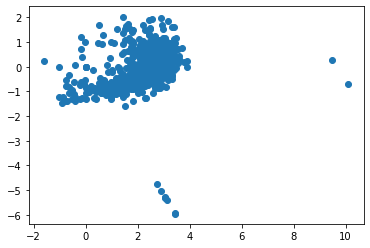

In [11]:
fig,ax = plt.subplots()
ax.scatter(df.x, df.y)
plt.show()

Final plot, after iteratively fiddling with the layout, the colours, the legend, etc.

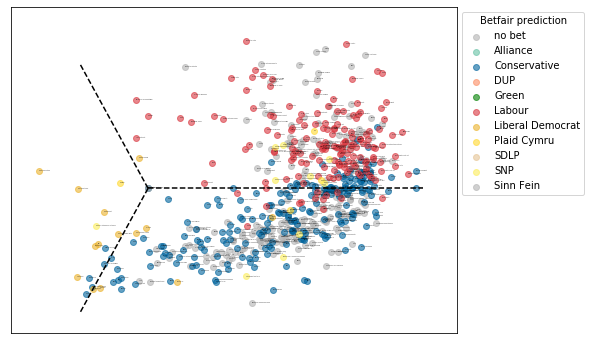

In [12]:
# We'll specify colours for the main parties, and leave the others on a
# standard colour palette.

parties = np.unique(df.predwin[~pandas.isna(df.predwin)])

def col(i):
    cols = {'Labour': (217,55,63), 
            'Conservative': (0,100,157), 
            'Liberal Democrat': (235,179,45),
            'SNP': (252,238,92),
            'Green': (0,128,0)}
    cols2 = plt.get_cmap('Set2', len(parties))
    if i in cols:
        return np.array(cols[i])/255
    elif pandas.isna(i):
        return '0.7'
    else:
        return cols2(np.where(parties==i)[0])


# Set up the plot
with plt.rc_context({'figure.figsize': (8,6)}):
    fig,ax = plt.subplots()
    
# Scatter plot, for each constituency, colour-coded by predicted winner
i = pandas.isna(df.predwin)
ax.scatter(df.x[i], df.y[i], label='no bet', alpha=.6, color=col(np.nan))
for p in parties:
    i = df.predwin==p
    ax.scatter(df.x[i], df.y[i], label=p, alpha=.6, color=col(p))

# Annotate with text (and trim some points that are out of bounds --
# ax.text doesn't respect xlim and ylim)
for i in np.arange(len(df)):
    if df.x[i]<4.5 and df.y[i]>-2:
        ax.text(df.x[i], df.y[i], df.ConstituencyName[i], fontsize=1)
    
# Grid lines, to lay out the axes showing which seats went which way in 2017
for (dx,dy,m) in party_style.values():
    ax.plot([0,-m*dx],[0,-m*dy], color='black', linestyle='dashed')

# Configure the scales
ax.set_xlim([-2,4.5])
ax.set_ylim([-2,2.5])
ax.set_xticks([])
ax.set_yticks([])
ax.legend(title='Betfair prediction', loc='upper left', bbox_to_anchor=(1,1,0,0))

# Save as pdf, so we can zoom and search the text labels
plt.savefig('predictions.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

plt.show()

# Appendix: code to fetch data from Betfair

To use the Betfair api, you need to create a Betfair account, and then an application key at https://docs.developer.betfair.com/visualisers/api-ng-account-operations/. 


In [ ]:
import requests
import json
from IPython.display import clear_output
import time
import pathlib
import pandas
import numpy as np

endpoint = "https://api.betfair.com/exchange/betting/rest/v1.0/"

In [ ]:
# Login

# I don't like to store sensitive data in a version-controlled Juputer notebook.
# Instead, I store credentials in a json file, not under version control.
# I have two-factor authentication turned on, so Betfair tells me to append
# an auth_code (from an Authenticator app on my phone) to the password field.

CREDENTIALS_FILE = 'betfair_creds.json'
with open(CREDENTIALS_FILE) as f:
    creds = json.loads(f.read())

auth_code = input()

conn = requests.Session()
conn.headers['Accept'] = 'application/json'
conn.headers['X-Application'] = creds['app_key']

r = conn.post('https://identitysso.betfair.com/api/login',
              data = {'username': creds['username'], 'password': creds['password'] + str(auth_code)}
              )
r.raise_for_status()
r = r.json()
assert r['status'] == 'SUCCESS'

conn.headers['X-Authentication'] = r['token']

In [ ]:
# Get a list of all constituencies

politics = conn.post(endpoint+'listEventTypes/', 
                     json = {'filter': {'textQuery':'Politics'}})
politics = politics.json()[0]['eventType']['id']
events = conn.post(endpoint+'listEvents/', 
                   json = {'filter' :{'eventTypeIds': [politics], 'textQuery':'Constituencies'}})
events = [int(e['event']['id']) for e in events.json()]
competitions = conn.post(endpoint+'listCompetitions/',
                        json = {'filter': {'eventIds': events}})
competitions = [int(c['competition']['id']) for c in competitions.json()]
markets = conn.post(endpoint+'listMarketCatalogue/',
                   json = {'filter': {'competitionIds': competitions},
                           'marketProjection': ['EVENT','COMPETITION'],
                           'maxResults': 1000})
markets = markets.json()

print(f"{len(markets)} markets")

In [ ]:
# Get current prices for all constituencies

res = {}

for i,market in enumerate(markets):
    m = market['marketId']
    if m in res: continue
    clear_output(wait=True)
    print(f'{i+1} / {len(markets)}')
    print(market)
    r = conn.post(endpoint+'listMarketCatalogue/',
                  json = {'filter': {'marketIds': [m]},
                          'marketProjection': ['RUNNER_DESCRIPTION'],
                          'maxResults': 1000})
    b = conn.post(endpoint+'listMarketBook/',
             json = {'marketIds': [m],
                     'priceProjection': {
                         'priceData': ["EX_BEST_OFFERS", "EX_TRADED"],
                         'virtualise': True
                     }
                     })
    res[m] = (market, r.json(), b.json())
    time.sleep(3)

with open('betfair_data.json', 'w') as f:
    json.dump(res, f)